<a href="https://colab.research.google.com/github/Gonzalez-Matias/Anyone_Sprint_3/blob/main/Project_3_Gonzalez_Enzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [ ]:
!pip install pyod

     |████████████████████████████████| 120 kB 4.3 MB/s 
     |████████████████████████████████| 38.1 MB 58.4 MB/s 
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147473 sha256=b13202b0ed223d49d61b0f54464d74aba4c8fe9070522a519933b96e6374bc50
  Stored in directory: /root/.cache/pip/wheels/ea/c4/29/67ad87835b209f72e4706369c683741b09490f2829d64ea768
Successfully built pyod
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
! pip install -q kaggle

In [ ]:
!pip install xgboost

In [ ]:
import time
import pandas as pd
import json
import xgboost as xgb
from datetime import datetime
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from google.colab import data_table
sns.set_theme()

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [ ]:
k = {"username":"user",
     "key":"key"}
with open('kaggle.json', 'w') as fp:
    json.dump(k, fp)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk
!mkdir home-credit-default-risk
!unzip home-credit-default-risk.zip -d home-credit-default-risk

 98% 677M/688M [00:21<00:00, 27.5MB/s]
100% 688M/688M [00:21<00:00, 33.7MB/s]
Archive:  home-credit-default-risk.zip
  inflating: home-credit-default-risk/HomeCredit_columns_description.csv  
  inflating: home-credit-default-risk/POS_CASH_balance.csv  
  inflating: home-credit-default-risk/application_test.csv  
  inflating: home-credit-default-risk/application_train.csv  
  inflating: home-credit-default-risk/bureau.csv  
  inflating: home-credit-default-risk/bureau_balance.csv  
  inflating: home-credit-default-risk/credit_card_balance.csv  
  inflating: home-credit-default-risk/installments_payments.csv  
  inflating: home-credit-default-risk/previous_application.csv  
  inflating: home-credit-default-risk/sample_submission.csv  


In [ ]:
loans_data_train = pd.read_csv("home-credit-default-risk/application_train.csv")
loans_data_test = pd.read_csv("home-credit-default-risk/application_test.csv")

In [ ]:
loans_data_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [ ]:
print("The shape of the training dataset is:")
loans_data_train.shape

The shape of the training dataset is:


(307511, 122)

In [ ]:
print("The shape of the testing dataset is:")
loans_data_test.shape

The shape of the testing dataset is:


(48744, 121)

2- List all columns in the train dataset

In [ ]:
cols = loans_data_train.columns
cols.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [ ]:
data_table.enable_dataframe_formatter()
first_records = loans_data_train.head(5).T
first_records

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


In [ ]:
data_table.disable_dataframe_formatter()

4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [ ]:
loans_data_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
loans_data_train.TARGET.value_counts()/len(loans_data_train)*100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

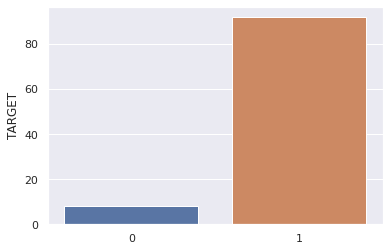

In [ ]:
ax = sns.barplot(x=loans_data_train.TARGET.unique(), y=loans_data_train.TARGET.value_counts()/len(loans_data_train)*100)
plt.show()

5- Show the number of columns of each data type

In [ ]:
object_columns=[]
float_columns=[]
int_columns=[]

for i in loans_data_train.columns:
  if loans_data_train[i].dtype == "object":
    object_columns.append(i)
  elif loans_data_train[i].dtype == "int64":
    int_columns.append(i)
  elif loans_data_train[i].dtype == "float64":
    float_columns.append(i)

In [ ]:
n_o_cols = len(object_columns)
n_fl_cols = len(float_columns)
n_int_cols = len(int_columns)

print(f"There are {n_o_cols} object columns.")
print(f"There are {n_fl_cols} float columns.")
print(f"There are {n_int_cols} integer columns.")

There are 16 object columns.
There are 65 float columns.
There are 41 integer columns.


6- For categorical variables, show the number of distinct values in each column (number of labels)

In [ ]:
tipos = pd.DataFrame(loans_data_train.dtypes, index=loans_data_train.columns)
tipos.columns = ["Tipo"]
tipos["N_categorias"] = "~"
tipos["Categorias"] = "~"
for col in loans_data_train.columns:
  if  tipos["Tipo"][col] == "object":
    tipos["N_categorias"][col] = loans_data_train[col].nunique()
    tipos["Categorias"][col] = str(list(loans_data_train[col].unique()))[1:-1]
tipos = tipos.loc[tipos.Categorias!="~"]

In [ ]:
data_table.enable_dataframe_formatter()
tipos

,Tipo,N_categorias,Categorias
NAME_CONTRACT_TYPE,object,2,"'Cash loans', 'Revolving loans'"
CODE_GENDER,object,3,"'M', 'F', 'XNA'"
FLAG_OWN_CAR,object,2,"'N', 'Y'"
FLAG_OWN_REALTY,object,2,"'Y', 'N'"
NAME_TYPE_SUITE,object,7,"'Unaccompanied', 'Family', 'Spouse, partner', ..."
NAME_INCOME_TYPE,object,8,"'Working', 'State servant', 'Commercial associ..."
NAME_EDUCATION_TYPE,object,5,"'Secondary / secondary special', 'Higher educa..."
NAME_FAMILY_STATUS,object,6,"'Single / not married', 'Married', 'Civil marr..."
NAME_HOUSING_TYPE,object,6,"'House / apartment', 'Rented apartment', 'With..."
OCCUPATION_TYPE,object,18,"'Laborers', 'Core staff', 'Accountants', 'Mana..."


In [ ]:
data_table.disable_dataframe_formatter()

7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(loans_data_train.isnull().sum().sort_values(ascending=False).head(20)/len(loans_data_train)*100)
pd.set_option("display.max_rows", 10, "display.max_columns", 10)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
FLOORSMIN_MEDI              67.848630
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_AVG             66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_MEDI               59.376738
LANDAREA_MODE               59.376738
LANDAREA_AVG                59.376738
dtype: float64


**Analyzing distribution of variables**

1- Show the distribution of credit amounts

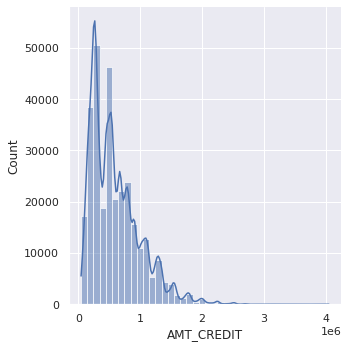

In [ ]:
sns.displot(data=loans_data_train, x="AMT_CREDIT", kde=True, bins=40)
plt.show()

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

In [ ]:
ed_level_data = pd.DataFrame(loans_data_train.NAME_EDUCATION_TYPE.value_counts().copy())
ed_level_data.columns = ["Count"]
ed_level_data["Percent"] = round(ed_level_data["Count"]/sum(ed_level_data["Count"])*100,2)

In [ ]:
fig = px.bar(ed_level_data,y=ed_level_data.index, x="Percent",hover_data=['Count'])
print(loans_data_train.NAME_EDUCATION_TYPE.value_counts())
fig.show()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


3- Plot the distribution of ocupation of the loan applicants

In [ ]:
occupation_data = pd.DataFrame(loans_data_train.OCCUPATION_TYPE.value_counts().copy())
occupation_data.columns = ["Count"]
occupation_data["Percent"] = round(occupation_data["Count"]/sum(occupation_data["Count"])*100,2)

In [ ]:
fig = px.bar(occupation_data,y=occupation_data.index, x="Percent",hover_data=['Count'])
fig.show()

4- Plot the family status of the applicants

In [ ]:
family_status_data = pd.DataFrame(loans_data_train.NAME_FAMILY_STATUS.value_counts().copy())
family_status_data.columns = ["Count"]
family_status_data["Percent"] = round(family_status_data["Count"]/sum(family_status_data["Count"])*100,2)

In [ ]:
fig = px.bar(family_status_data,y=family_status_data.index, x="Percent",hover_data=['Count'])
fig.show()

5- Plot the income type of applicants grouped by the target variable

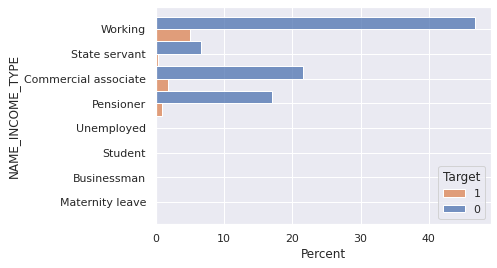

In [ ]:
ax = sns.histplot(loans_data_train,
             y="NAME_INCOME_TYPE",
             hue="TARGET",
             stat="percent", 
             multiple="dodge"
             ).legend(['1', '0'], loc='lower right', title='Target')
plt.show()

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [ ]:
loans_data_train = pd.read_csv("home-credit-default-risk/application_train.csv")
loans_data_test = pd.read_csv("home-credit-default-risk/application_test.csv")

In [ ]:
def pre_processing(X_trn, X_tst):
  '''
  It makes all the data preprocessing for the dataset and returns 
  the transformed data as numpy arrays ready to be used for training.
  '''

  #First, the function separates the numerical columns from the categorical ones
  '''
  In this first step, I let out the target and id column because they are not going to be preprocessed.
  '''
  categorical_features = loans_data_train.select_dtypes(include="object").columns
  numeric_features = loans_data_train.select_dtypes(include=["int64","float64"]).columns.drop(["TARGET","SK_ID_CURR"])

  #Imputes values for all columns with missing data 
  '''
  In this step, the function makes sure that there aren't any missing values by filing them with median or mode
  '''
  imput_num = SimpleImputer(strategy='median')
  imput_num.fit(X_trn[numeric_features])
  X_trn[numeric_features] = imput_num.transform(X_trn[numeric_features])
  X_tst[numeric_features] = imput_num.transform(X_tst[numeric_features])

  imput_num = SimpleImputer(strategy='most_frequent')
  imput_num.fit(X_trn[categorical_features])
  X_trn[categorical_features] = imput_num.transform(X_trn[categorical_features])
  X_tst[categorical_features] = imput_num.transform(X_tst[categorical_features])

  #Corrects outliers/anomalous values in numerical columns
  '''
  I decided to change the positives outliers on days employed to 0 and added a column with 1 in every position that didn't have those values 
  due to the fact that those rows meant unemployed people and I didn't want to lose that information. New column --> FLAG_EMPLOYED
  I also drop a massive outlier in AMT_INCOME_TOTAL.
  '''
  unemployed_list_train = X_trn.loc[X_trn["DAYS_EMPLOYED"]>=0].index
  unemployed_list_test = X_tst.loc[X_tst["DAYS_EMPLOYED"]>=0].index
  X_trn["FLAG_EMPLOYED"] = 1
  X_tst["FLAG_EMPLOYED"] = 1
  X_trn.loc[unemployed_list_train, ["FLAG_EMPLOYED"]] = 0 
  X_tst.loc[unemployed_list_test, ["FLAG_EMPLOYED"]] = 0 
  X_trn.loc[X_trn["DAYS_EMPLOYED"]>=0, ["DAYS_EMPLOYED"]] = 0
  X_tst.loc[X_tst["DAYS_EMPLOYED"]>=0, ["DAYS_EMPLOYED"]] = 0

  X_trn = X_trn.loc[X_trn["AMT_INCOME_TOTAL"]<=9_000_000]

  #Encodes categorical features and does the feature scaling
  '''
  Here the function does an encoding of the categorical features, scales the numeric columns, and gives the dataframe a numpy format
  '''
  X_train =  X_trn.drop(columns=["TARGET","SK_ID_CURR"])
  X_tst = X_tst.drop(columns=["SK_ID_CURR"])
  y_train = X_trn["TARGET"]

  preprocessor = ColumnTransformer(transformers=[("num",QuantileTransformer(), selector(dtype_include=np.number)),
                                                 ("cat", OneHotEncoder(handle_unknown='ignore', drop="if_binary"), selector(dtype_include=object))], remainder="passthrough")
  
  X_train = preprocessor.fit_transform(X_train)
  X_tst = preprocessor.transform(X_tst)
  X_trn = np.concatenate([X_train, y_train.to_numpy().reshape(-1,1)], axis=1)

  return X_trn, X_tst

In [ ]:
X_train, X_test = pre_processing(X_trn=loans_data_train, X_tst=loans_data_test)

In [ ]:
X_train

array([[0.        , 0.73873874, 0.38697278, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.89239239, 0.93593594, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05155155, 0.04454454, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.50550551, 0.66166166, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.61011011, 0.36247563, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.54954955, 0.64664665, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X_train.shape

(307508, 242)

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [ ]:
baseline_model = LogisticRegression(max_iter=2000)

In [ ]:
baseline_model.fit(X_train[:,:-1], X_train[:,-1])

LogisticRegression(max_iter=2000)

2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [ ]:
resp = baseline_model.predict_proba(X_test)

In [ ]:
loans_data_test["TARGET"] = resp[:,1]

In [ ]:
resp = loans_data_test[["SK_ID_CURR","TARGET"]]
resp.to_csv("Baseline_model.csv", index = False)

In [ ]:
loans_data_test.drop(columns = ["TARGET"], inplace=True)

3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f Baseline_model.csv -m "" -q

Successfully submitted to Home Credit Default Risk

In [ ]:
!kaggle competitions submissions -v home-credit-default-risk > SomeFile.csv
re = pd.read_csv("SomeFile.csv")
print(re.loc[re.fileName =="Baseline_model.csv"][["fileName","status","privateScore"]])
del re

             fileName    status  privateScore
0  Baseline_model.csv  complete        0.7303


At this point, the model should produce a result around 0.67 

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
RF_model_dfl = RandomForestClassifier(n_jobs=-1, random_state=8)

In [ ]:
start_time = datetime.now()
RF_model_dfl.fit(X_train[:,:-1], X_train[:,-1])
end_time = datetime.now()
time = end_time-start_time
print(time)

0:03:11.429674


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
pred = RF_model_dfl.predict_proba(X_test)
pred[:,1]

array([0.05, 0.13, 0.06, ..., 0.04, 0.11, 0.14])

3- Load the predictions to the competition. Report the private score here.

In [ ]:
loans_data_test["TARGET"] = pred[:,1]
resp = loans_data_test[["SK_ID_CURR","TARGET"]]
resp.to_csv("Random_forest_model.csv", index = False)
loans_data_test.drop(columns = ["TARGET"], inplace=True)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f Random_forest_model.csv -m "" -q

Successfully submitted to Home Credit Default Risk

In [ ]:
!kaggle competitions submissions -v home-credit-default-risk > SomeFile.csv
re = pd.read_csv("SomeFile.csv")
print(re.loc[re.fileName =="Random_forest_model.csv"][["fileName","status","privateScore"]])
del re

                  fileName    status  privateScore
0  Random_forest_model.csv  complete       0.69127


### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [ ]:
### Complete in this cell: Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier
example_hyperparameter_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200]
}

In [ ]:
RF_model_tnd = RandomForestClassifier(n_jobs=-1, random_state=8)

clf = RandomizedSearchCV(RF_model_tnd, example_hyperparameter_grid, scoring="roc_auc", cv=5, random_state=4)
search = clf.fit(X_train[:,:-1], X_train[:,-1])

In [ ]:
search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
RF_model_tnd = RandomForestClassifier(n_jobs=-1, random_state=8, bootstrap=False, max_depth=None, max_features="sqrt", min_samples_leaf=4, min_samples_split=2, n_estimators=200)

In [ ]:
start_time = datetime.now()
RF_model_tnd.fit(X_train[:,:-1], X_train[:,-1])
end_time = datetime.now()
time = end_time-start_time
print(time)

0:07:22.707245


In [ ]:
pred2 = RF_model_tnd.predict_proba(X_test)
pred2[:,1]

array([0.06409343, 0.10103589, 0.02148585, ..., 0.05495833, 0.04568155,
       0.12092857])

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
loans_data_test["TARGET"] = pred2[:,1]
resp = loans_data_test[["SK_ID_CURR","TARGET"]]
resp.to_csv("Random_tuned_model.csv", index = False)
loans_data_test.drop(columns = ["TARGET"], inplace=True)

3- Load the predictions to the competition. Report the private score here.

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f Random_tuned_model.csv -m "" -q

Successfully submitted to Home Credit Default Risk

In [ ]:
!kaggle competitions submissions -v home-credit-default-risk > SomeFile.csv
re = pd.read_csv("SomeFile.csv")
print(re.loc[re.fileName =="Random_tuned_model.csv"][["fileName","status","privateScore"]])
del re

                 fileName    status  privateScore
0  Random_tuned_model.csv  complete       0.72132


4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
light_model = LGBMClassifier()

In [ ]:
light_model.fit(X_train[:,:-1], X_train[:,-1])

LGBMClassifier()

In [ ]:
pred3 = light_model.predict_proba(X_test)
pred3[:,1]

array([0.0372326 , 0.11988506, 0.01756002, ..., 0.03934192, 0.06487032,
       0.15986821])

In [ ]:
loans_data_test["TARGET"] = pred3[:,1]
resp = loans_data_test[["SK_ID_CURR","TARGET"]]
resp.to_csv("LightGBM_model.csv", index = False)
loans_data_test.drop(columns = ["TARGET"], inplace=True)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f LightGBM_model.csv -m "" -q

Successfully submitted to Home Credit Default Risk

In [ ]:
!kaggle competitions submissions -v home-credit-default-risk > SomeFile.csv
re = pd.read_csv("SomeFile.csv")
print(re.loc[re.fileName =="LightGBM_model.csv"][["fileName","status","privateScore"]])
del re

             fileName    status  privateScore
0  LightGBM_model.csv  complete       0.74209


### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [ ]:
X_train = pd.read_csv("home-credit-default-risk/application_train.csv")
X_test = pd.read_csv("home-credit-default-risk/application_test.csv")

In [ ]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), 
                                      ("scaler", QuantileTransformer())])

categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                                          ('encoder',OneHotEncoder(handle_unknown='ignore', drop="if_binary"))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,  selector(dtype_include=np.number)),
                                               ("cat", categorical_transformer, selector(dtype_include=object))])

pipe_model = Pipeline(steps=[("preprocessor", preprocessor), 
                             ("classifier", LGBMClassifier(n_jobs=-1, random_state=8, n_estimators=95, objective="binary"))])

In [ ]:
pipe_model.fit(X_train.drop(columns = ["TARGET","SK_ID_CURR"]), X_train["TARGET"]);

In [ ]:
pipe_pred = pipe_model.predict_proba(X_test.drop(columns=["SK_ID_CURR"]))[:,1]

In [ ]:
X_test["TARGET"] = pipe_pred
resp = X_test[["SK_ID_CURR","TARGET"]]
resp.to_csv("lgbm.csv", index = False)
X_test.drop(columns = ["TARGET"], inplace=True)

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f lgbm.csv -m "" -q

Successfully submitted to Home Credit Default Risk

In [ ]:
!kaggle competitions submissions -v home-credit-default-risk > SomeFile.csv
re = pd.read_csv("SomeFile.csv")
print(re.loc[re.fileName =="lgbm.csv"][["fileName","status","privateScore"]])
del re

   fileName    status  privateScore
0  lgbm.csv  complete       0.74362
